# Downloading Dataset

In [1]:
!kaggle datasets download -d syedtouqeer/classification-decision-tree-classifier --unzip -f Social_network_ads.csv

Dataset URL: https://www.kaggle.com/datasets/syedtouqeer/classification-decision-tree-classifier
License(s): unknown
Social_Network_Ads.csv: Skipping, found more recently modified local copy (use --force to force download)


Filter out warnings to make notebook cleaner (Mostly from cross-validation parameters not being compatible and ANOVA rank interactions)

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
import pandas as pd

df = pd.read_csv("Social_network_ads.csv")
df.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


Selection of Features and Encoding of Booleans

In [4]:
features = ["Age", "EstimatedSalary", "Gender"]
target = ["Purchased"]
data = df[features + target]
data["Gender"] = data["Gender"].map({"Male": 0, "Female": 1}).copy()

# Exploratory Data Analysis

In [5]:
data["Gender"].value_counts()

Gender
1    204
0    196
Name: count, dtype: int64

In [6]:
data.describe()

,Age,EstimatedSalary,Gender,Purchased
count,400.000000,400.000000,400.000000,400.000000
mean,37.655000,69742.500000,0.510000,0.357500
std,10.482877,34096.960282,0.500526,0.479864
min,18.000000,15000.000000,0.000000,0.000000
25%,29.750000,43000.000000,0.000000,0.000000
50%,37.000000,70000.000000,1.000000,0.000000
75%,46.000000,88000.000000,1.000000,1.000000
max,60.000000,150000.000000,1.000000,1.000000


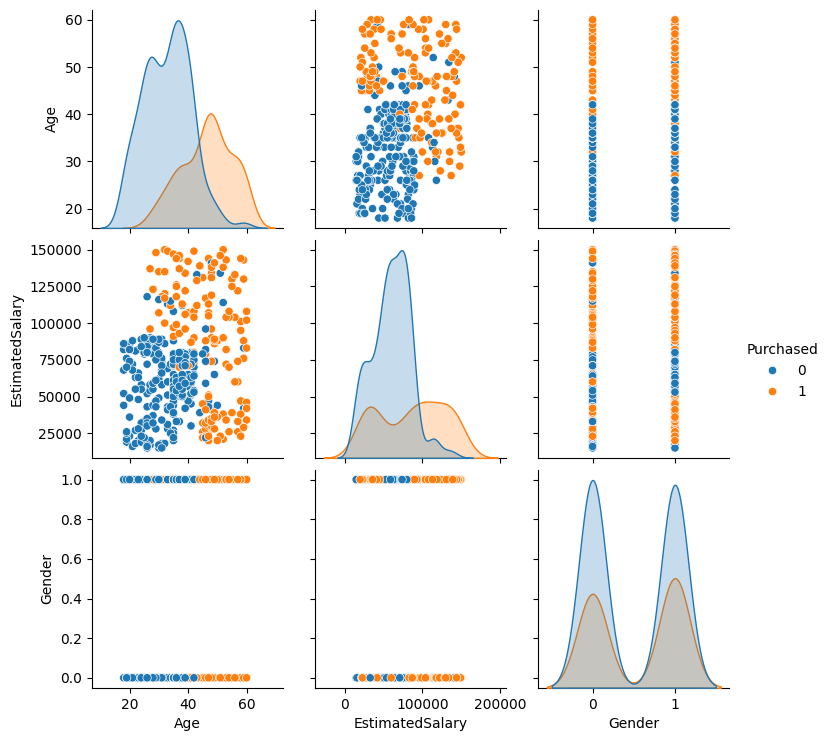

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(data, hue="Purchased")
plt.show()

Purchasers are older and make more money.


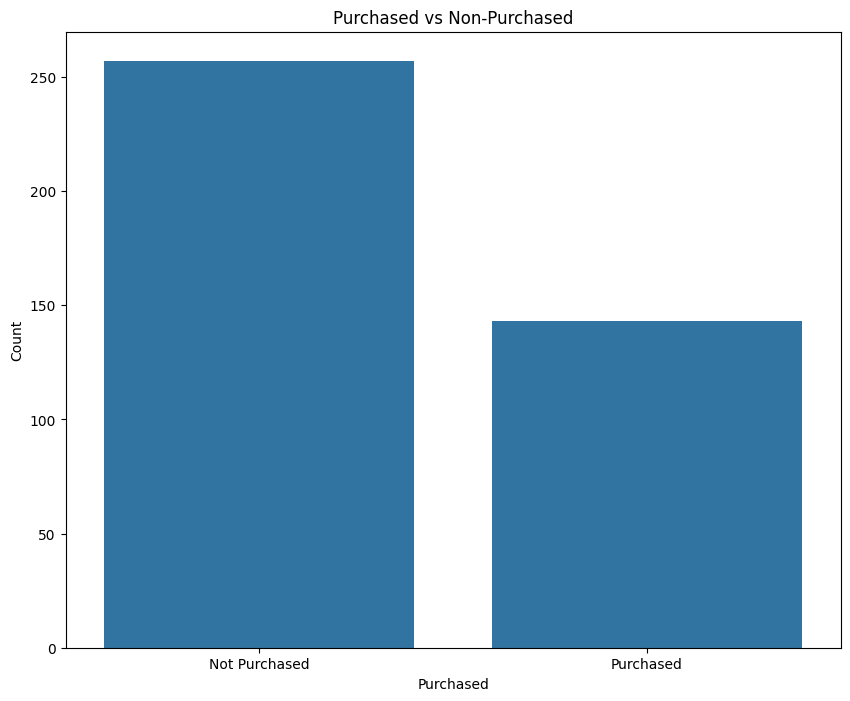

In [8]:
plt.figure(figsize=(10, 8))
sns.countplot(x="Purchased", data=data)
df["Purchased"].value_counts(normalize=True)
plt.title("Purchased vs Non-Purchased")
plt.xticks([0, 1], ["Not Purchased", "Purchased"])
plt.xlabel("Purchased")
plt.ylabel("Count")
plt.show()

Non-purchasers almost double the purchasers

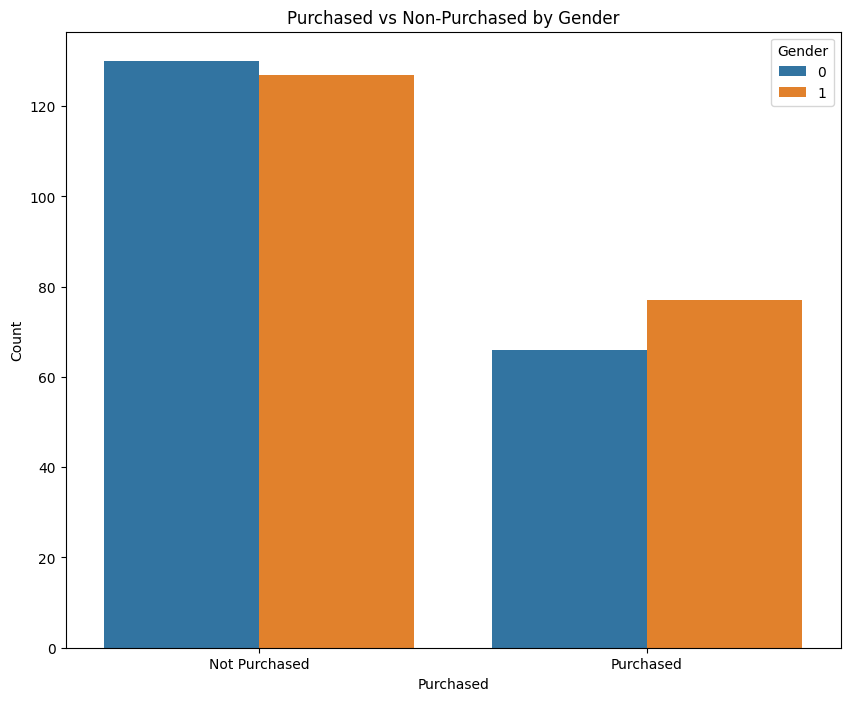

In [9]:
plt.figure(figsize=(10, 8))
sns.countplot(x="Purchased", data=data, hue="Gender")
plt.title("Purchased vs Non-Purchased by Gender")
plt.xticks([0, 1], ["Not Purchased", "Purchased"])
plt.xlabel("Purchased")
plt.ylabel("Count")
plt.show()

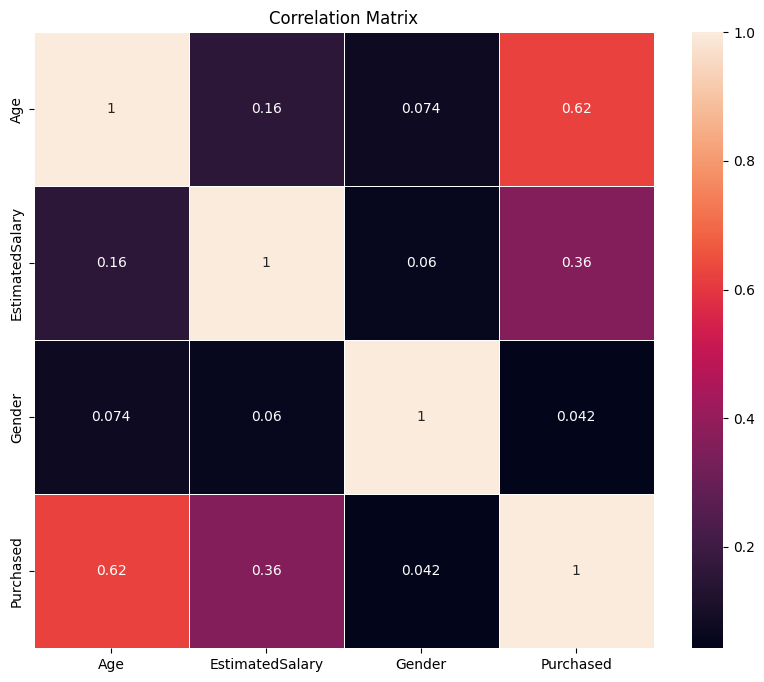

In [10]:
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, linewidths=0.5, linecolor="white")
plt.title("Correlation Matrix")
plt.show()

Age has good corelation

In [11]:
import pingouin as pg

pg.anova(data=data, dv="Purchased", between=features)

/Users/dna/.pyenv/versions/3.11.10/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 42, but rank is 4
  warnings.warn('covariance of constraints does not have full '
/Users/dna/.pyenv/versions/3.11.10/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 116, but rank is 10
  warnings.warn('covariance of constraints does not have full '
/Users/dna/.pyenv/versions/3.11.10/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 1, but rank is 0
  warnings.warn('covariance of constraints does not have full '
/Users/dna/.pyenv/versions/3.11.10/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constrai

,Source,SS,DF,MS,F,p-unc,np2
0,Age,14.209200,42.0,0.338314,14.209200,9.198915e-06,0.966008
1,EstimatedSalary,14.356426,116.0,0.123762,5.198016,7.275415e-04,0.966345
2,Gender,NaN,1.0,NaN,NaN,NaN,NaN
3,Age * EstimatedSalary,17909.397767,4872.0,3.675985,154.391360,6.326006e-18,0.999972
4,Age * Gender,17.890257,42.0,0.425958,17.890257,1.569265e-06,0.972812
5,EstimatedSalary * Gender,15.513128,116.0,0.133734,5.616822,4.368322e-04,0.968776
6,Age * EstimatedSalary * Gender,1215.277041,4872.0,0.249441,10.476526,4.301655e-08,0.999589
7,Residual,0.500000,21.0,0.023810,NaN,NaN,NaN


All interaction terms are significant

In [12]:
data["Age_x_EstimatedSalary"] = data["Age"] * data["EstimatedSalary"]
data["Age_x_Gender"] = data["Age"] * data["Gender"]
data["EstimatedSalary_x_Gender"] = data["EstimatedSalary"] * data["Gender"]
data["Age_x_EstimatedSalary_x_Gender"] = data["Age"] * data["EstimatedSalary"] * data["Gender"]

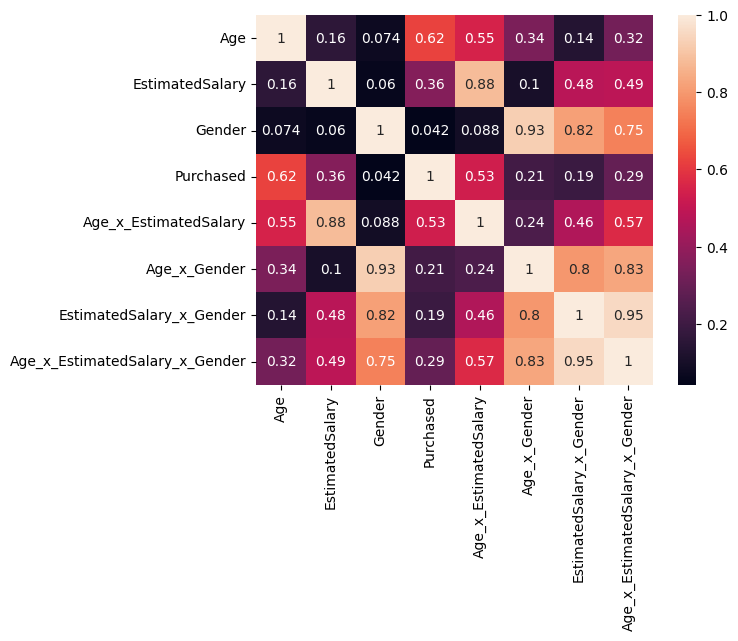

In [13]:
sns.heatmap(data.corr(), annot=True)
plt.show()

# Model Building & Evaluation

In [14]:
import sklearn.tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    make_scorer,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    balanced_accuracy_score,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

sklearn.tree._tree.BACKEND = "mps"

X_train, X_test, y_train, y_test = train_test_split(
    data[features], data[target], test_size=0.2, random_state=414
)

# Model consists of a pipeline with a standardizer, PCA, and a decision tree classifier


In [15]:
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("pca", PCA()),
        ("tree", DecisionTreeClassifier(random_state=414)),
    ]
)

param_grid = {
    "tree__max_depth": [2, 3, 4, 5, 6, 7, 8, 9, 10],
    "tree__min_samples_leaf": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "tree__criterion": ["gini", "entropy", "log_loss"],
}

kf = KFold(n_splits=5, shuffle=True, random_state=414)

tree_cv = GridSearchCV(
    pipeline,
    param_grid,
    cv=kf,
    n_jobs=-1,
    scoring={
        "balanced_accuracy": make_scorer(balanced_accuracy_score),
        "accuracy": make_scorer(accuracy_score),
        "precision": make_scorer(precision_score, average="weighted"),
        "recall": make_scorer(recall_score, average="weighted"),
        "f1": make_scorer(f1_score, average="weighted"),
        "roc_auc": make_scorer(roc_auc_score, response_method="predict"),
    },
    refit="balanced_accuracy",
)
tree_cv.fit(X_train, y_train)

preds = tree_cv.predict(X_test)

In [16]:
print(f"Best Parameters: {tree_cv.best_params_}")

Best Parameters: {'tree__criterion': 'gini', 'tree__max_depth': 4, 'tree__min_samples_leaf': 9}


In [17]:
print(f"Best Training Balanced Accuracy: {tree_cv.best_score_}")

Best Training Balanced Accuracy: 0.9131235322681025


# Model Evaluation

In [18]:
cv = cross_val_score(
    tree_cv, data[features], data[target], cv=kf, scoring="balanced_accuracy", n_jobs=-1
)

/Users/dna/.pyenv/versions/3.11.10/lib/python3.11/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/Users/dna/.pyenv/versions/3.11.10/lib/python3.11/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [19]:
print(
    f"Cross Validation Mean Balanced Accuracy: {cv.mean()}\nCross Validation Standard Deviation: {cv.std()}"
)

Cross Validation Mean Balanced Accuracy: 0.8956435001717648
Cross Validation Standard Deviation: 0.0229459871348444


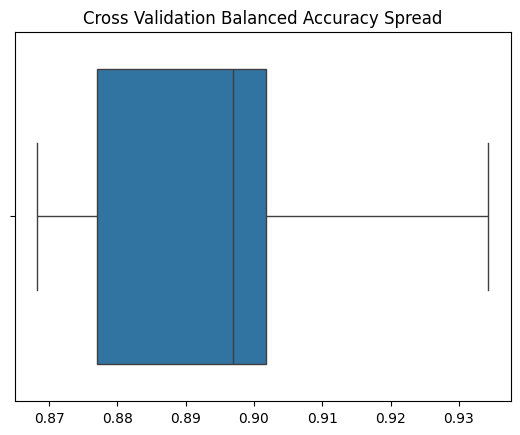

In [20]:
sns.boxplot(x=cv)
plt.title("Cross Validation Balanced Accuracy Spread")
plt.show()

Model Struggled to predict purchasers more than non-purchasers

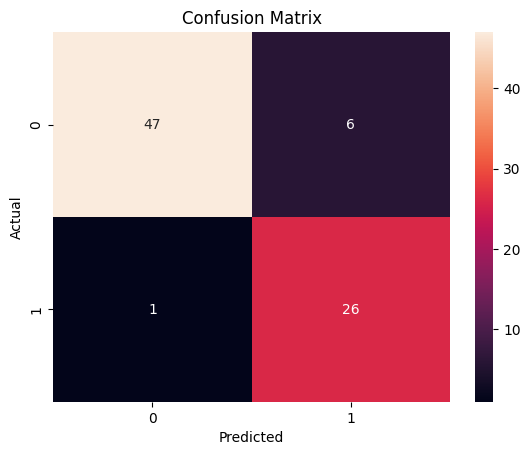

In [21]:
sns.heatmap(confusion_matrix(y_test, preds), annot=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [22]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.98      0.89      0.93        53
           1       0.81      0.96      0.88        27

    accuracy                           0.91        80
   macro avg       0.90      0.92      0.91        80
weighted avg       0.92      0.91      0.91        80



In [23]:
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, preds)}")

Balanced Accuracy: 0.9248777078965758


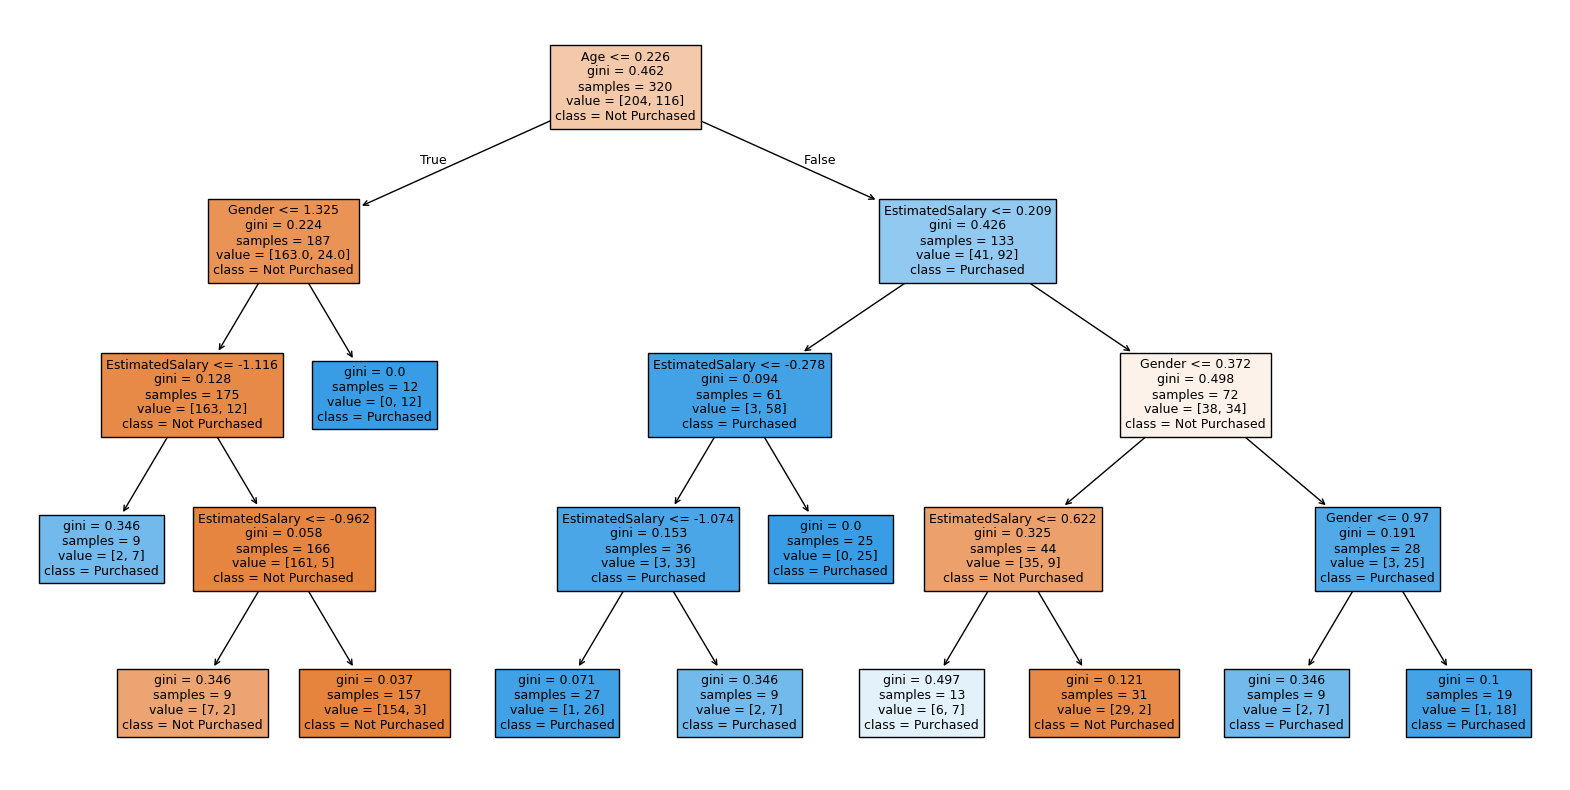

In [24]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(
    tree_cv.best_estimator_.named_steps["tree"],
    filled=True,
    feature_names=features,
    class_names=["Not Purchased", "Purchased"],
)
plt.show()

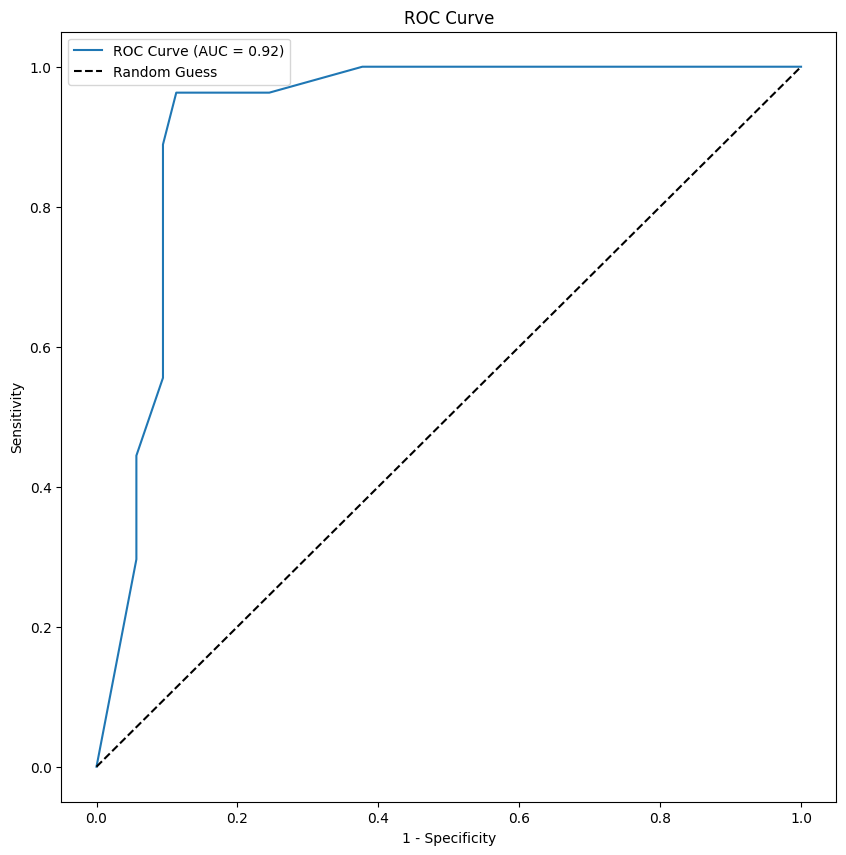

In [25]:
from sklearn.metrics import roc_curve, auc

preds_prob = tree_cv.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, preds_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 10))

plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")

plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
plt.title("ROC Curve")

plt.legend()
plt.show()